In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suyashlakhani/apple-stock-prices-20152020")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'apple-stock-prices-20152020' dataset.
Path to dataset files: /kaggle/input/apple-stock-prices-20152020


In [52]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print("Train size:", len(train), "Test size:", len(test))


Train size: 1006 Test size: 252


In [53]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ARIMA Rolling RMSE: 6.633162179218423
ARIMA Rolling MAPE: 1.6294428796199605


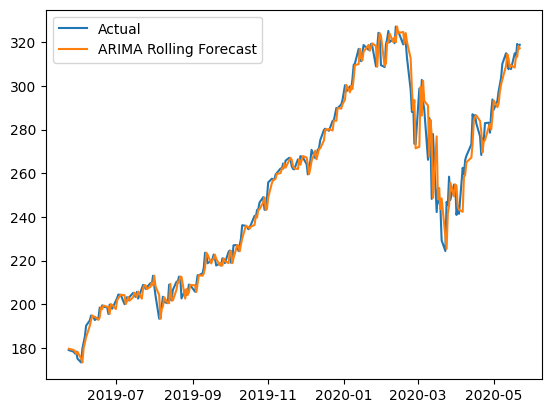

In [54]:
history = list(train['close'])
arima_preds = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    arima_preds.append(yhat)
    history.append(test['close'].iloc[t])

print("ARIMA Rolling RMSE:", rmse(test['close'], arima_preds))
print("ARIMA Rolling MAPE:", mape(test['close'], arima_preds))

plt.plot(test.index, test['close'], label="Actual")
plt.plot(test.index, arima_preds, label="ARIMA Rolling Forecast")
plt.legend()
plt.show()

In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['close']])

def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 30
train_scaled = scaled_data[:train_size]
test_scaled  = scaled_data[train_size-seq_len:]

X_train, y_train = create_sequences(train_scaled, seq_len)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [56]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_len,1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0304
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8807e-04
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.7487e-04
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.4848e-04


LSTM Rolling RMSE: 13.462030058075648
LSTM Rolling MAPE: 4.125158426071953


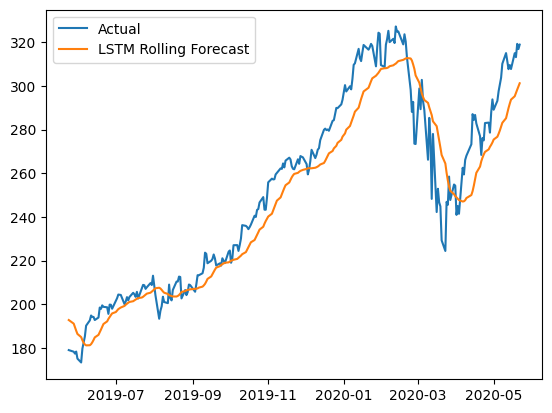

In [57]:
history_scaled = list(train_scaled.ravel())
lstm_preds = []

for t in range(len(test)):

    last_window = np.array(history_scaled[-seq_len:]).reshape(1, seq_len, 1)
    pred_scaled = model.predict(last_window, verbose=0)[0,0]
    lstm_preds.append(pred_scaled)

    history_scaled.append(test_scaled[t+seq_len,0])


lstm_preds = scaler.inverse_transform(np.array(lstm_preds).reshape(-1,1)).ravel()

print("LSTM Rolling RMSE:", rmse(test['close'], lstm_preds))
print("LSTM Rolling MAPE:", mape(test['close'], lstm_preds))

plt.plot(test.index, test['close'], label="Actual")
plt.plot(test.index, lstm_preds, label="LSTM Rolling Forecast")
plt.legend()
plt.show()


Performance Comparison:


,Model,RMSE,MAPE(%)
0,ARIMA,6.633162,1.629443
1,LSTM,13.462030,4.125158


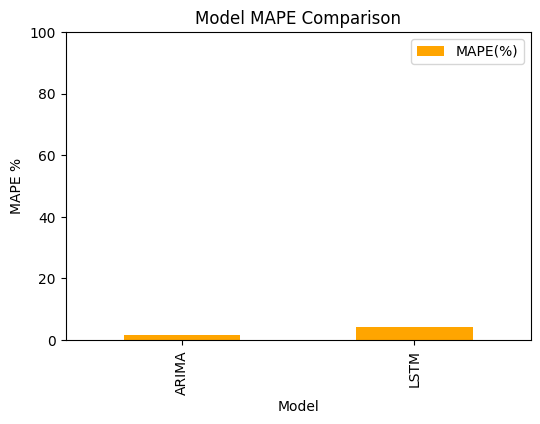

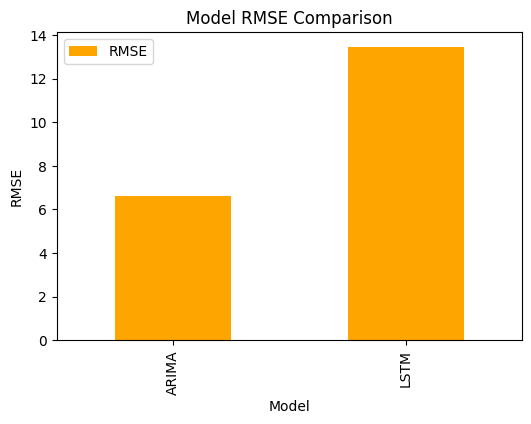

In [58]:
results = pd.DataFrame([
    {"Model": "ARIMA", "RMSE": rmse(test['close'], arima_preds), "MAPE(%)": mape(test['close'], arima_preds)},
    {"Model": "LSTM",  "RMSE": rmse(test['close'], lstm_preds), "MAPE(%)": mape(test['close'], lstm_preds)}
])

print("\nPerformance Comparison:")
display(results)

results.set_index("Model")[["MAPE(%)"]].plot(kind='bar', figsize=(6,4), ylim=(0,100), color=['orange','green'])
plt.title("Model MAPE Comparison")
plt.ylabel("MAPE %")
plt.show()

results.set_index("Model")[["RMSE"]].plot(kind='bar', figsize=(6,4), color=['orange','green'])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()